# DebyeCalculator - Tutorial

**Authors:** Johansen & Anker et. al.

**Date:** August 2023

---
The `DebyeCalculator` class is a powerful tool for calculating the scattering intensity I(Q) and pair distribution function G(r) of atomic structures using the Debye scattering equation. This class is optimized to run on GPUs, making it well-suited for large-scale simulations and nanoparticle analysis. It utilizes PyTorch to efficiently perform tensor computations and takes advantage of CUDA acceleration for enhanced speed.

In this notebook, we will demonstrate how to use the `DebyeCalculator` class to calculate I(Q) and G(r) for nanoparticles generated from a given atomic structure.

Let's get started with an overview of the `DebyeCalculator` class and its main functionalities.

First, import the relavant python packages by running the cell below

In [1]:
import os
os.chdir('../packages')

import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from debye_calculator import DebyeCalculator
from generate_nanoparticles import generate_nanoparticles

---
## Creating an Instance of DebyeCalculator

To use the `DebyeCalculator` class, you need to create an instance of it. The constructor of the class allows you to set various parameters for the Debye scattering calculations. Here's how you can create an instance:

```python
from debye_calculator import DebyeCalculator

# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(
    qmin=0.0,
    qmax=30.0,
    qstep=0.1,
    qdamp=0.0,
    rmin=0.0,
    rmax=20.0,
    rstep=0.01,
    rthres=0.0,
    biso=0.0,
    device='cuda',
    batch_size=None,
    lorch_mod=False,
    radiation_type='xray',
    verbose=0,
)

# Arguments for DebyeCalculator class

# Standard Debye parameters
qmin = 0.0        # Minimum Q (1/Å)
qmax = 30.0       # Maximum Q (1/Å)
qstep = 0.1       # Step size for Q (1/Å)
qdamp = 0.0       # Debye-Waller damping factor

# Parameters for pair distribution function (G(r)) calculations
rmin = 0.0        # Minimum R (Å)
rmax = 20.0       # Maximum R (Å)
rstep = 0.01      # Step size for R (Å)
rthres = 0.0      # Lower threshold (Å) radial distance for G(r) calculations

# Debye-Weller isotropic atomic displacement factor
biso = 0.0

# Device selection
device = 'cuda'   # Use 'cuda' for GPU or 'cpu' for CPU

# Batch size for pairwise distance calculations (if not specified, it will be automatically determined)
batch_size = None

# Lorch modification factor for G(r) calculations
lorch_mod = False

# Radiation type for scattering calculations
radiation_type = 'xray'  # Use 'xray' or 'neutron'

# Verbosity level (0 for minimal output)
verbose = 0

```

In [2]:
# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(device='cuda', verbose=1, qmin=1, qmax=25, qstep=0.1, biso=0.3)

---
## Generating Nanoparticles
In this section, we will demonstrate how to use the utility function `generate_nanoparticle` to generate nanoparticles for use in the `DebyeCalculator` class. he utility function allows you to create a nanoparticle supercell based on the input atomic structure from `.cif` files. Alternatively, you can input any `.xyz` file or any `Atoms` object from the ASE package into the `DebyeCalculator` class.

**Note:** The utility function generate_nanoparticle strictly takes `.cif` files as input since it generates nanoparticles from supercells of the unit cells provided by the `.cif` files.

**Usage:**
To create nanoparticles, use the following function:

```python
from nanoparticle_utils import generate_nanoparticle

generate_nanoparticle(structure_path, radii, sort_atoms=True)
```

**Parameters:**
* `structure_path`: The path to the input atomic structure `.cif` file.
* `radii`: A list of radii for which nanoparticles will be generated.
* `sort_atoms`: (Optional) Whether to sort the atoms in the nanoparticle based on distance to the center. Defaults to `True`.

**Output:**
The function returns a list of nanoparticle supercells, each corresponding to a specific radius from the radii list.
It also returns a list of nanoparticle sizes (diameters) for each nanoparticle generated.

**Example:**
```python
# Example usage with an .cif file
structure_path = "path/to/atomic_structure.cif"
radii = [10, 15, 20]  # Radii for nanoparticle generation

# Generate nanoparticles
nano_particles, particle_sizes = generate_nanoparticle(structure_path, radii)
```

Now, you can use the generated nanoparticle supercells and calculate I(Q) and G(r) using the DebyeCalculator class. You can either use the nanoparticle supercells directly or choose to import an atomic structure using the ASE package.

In [3]:
# Load the structure file
structure_path = '../example_data/AntiFlourite_Co2O.cif'

# Generate nanoparticles
radii = [5.0, 10.0]  # Sample radii for nanoparticles
nano_particles, nano_sizes = generate_nanoparticles(structure_path, radii)

Generating nanoparticles:   0%|          | 0/2 [00:00<?, ?it/s]

---
## Calculating I(Q) and G(r) with DebyeCalculator

Now that we have nanoparticle supercells ready, let's explore how to use the `DebyeCalculator` class to calculate the scattering intensity (I(Q)) and pair distribution function (G(r)) for these nanoparticles.

#### Calculating I(Q):

To calculate the scattering intensity I(Q) for a nanoparticle, you can use the `iq` method of the `DebyeCalculator` class. This method takes the nanoparticle supercell and returns the scattering intensity I(Q) at the specified Q values.

```python
# Example usage to calculate I(Q) for a single nanoparticle
from DebyeCalculator import DebyeCalculator

# Create an instance of DebyeCalculator with appropriate parameters
calculator = DebyeCalculator(qmin=0.0, qmax=30.0, qstep=0.1, qdamp=0.0)

# Load a single nanoparticle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
nanoparticle_xyz_file = "path/to/nanoparticle.xyz"
q_values, scattering_intensity = calculator.iq(nanoparticle_xyz_file)

```
**Note:** The example above demonstrates how to calculate I(Q) for a single nanoparticle using an `.xyz` file. You can alternatively generate `Atoms` objects as demonstrated above and parse these instead of the `.xyz` path.  You can also repeat the process for multiple nanoparticles in a loop to obtain scattering intensities for all nanoparticles.

#### Calculating G(r):

To calculate the pair distribution function G(r) for a nanoparticle, you can use the gr method of the `DebyeCalculator` class. This method takes either a path to a `.xyz` file or an `Atoms` object from ASE and returns the G(r) values at the specified r values.

```python

# Example usage to calculate G(r) for a single nanoparticle
from DebyeCalculator import DebyeCalculator

# Create an instance of DebyeCalculator with appropriate parameters
calculator = DebyeCalculator(qmin=0.0, qmax=30.0, qstep=0.1, qdamp=0.0, rmin=0.0, rmax=20.0, rstep=0.01)

# Load a single nanoparticle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
nanoparticle_xyz_file = "path/to/nanoparticle.xyz"
r_values, pair_distribution = calculator.gr(nanoparticle_xyz_file)

```
**Note:** The example above demonstrates how to calculate G(r) for a single nanoparticle using an `.xyz` file. You can alternatively generate `Atoms` objects as demonstrated above and parse these instead of the `.xyz` path.  You can also repeat the process for multiple nanoparticles in a loop to obtain scattering intensities for all nanoparticles.

---
The code below showcases I(Q), S(Q), F(Q) and G(r) for the three nanoparticles that we generated above.

In [4]:
from diffpy.structure import loadStructure
from diffpy.srreal.pdfcalculator import DebyePDFCalculator

In [5]:
# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(device='cuda', verbose=1, qmin=1, qmax=25, qstep=0.1, biso=0.3)

# Calculate I(Q) and G(r) for the nanoparticles
results_iq = []
results_sas = []
results_fq = []
results_gr = []

pbar = tqdm(desc='Generating data', total=len(nano_particles), leave=True)
for i, particle in enumerate(nano_particles):
    debye_calc.update_parameters(qmin=1, qmax=25, qstep=0.1)
    q, iq_dc = debye_calc.iq(particle)
    _, fq_dc = debye_calc.fq(particle)
    r, gr_dc = debye_calc.gr(particle)
    
    debye_calc.update_parameters(qmin=0, qmax=2, qstep=0.01)
    q_sas, sas_dc = debye_calc.iq(particle)
    
    results_iq.append(iq_dc)
    results_sas.append(sas_dc)
    results_fq.append(fq_dc)
    results_gr.append(gr_dc)
    
    pbar.update()

Generating data:   0%|          | 0/2 [00:00<?, ?it/s]

Nanoparticle 1: Size: 12.641 Å


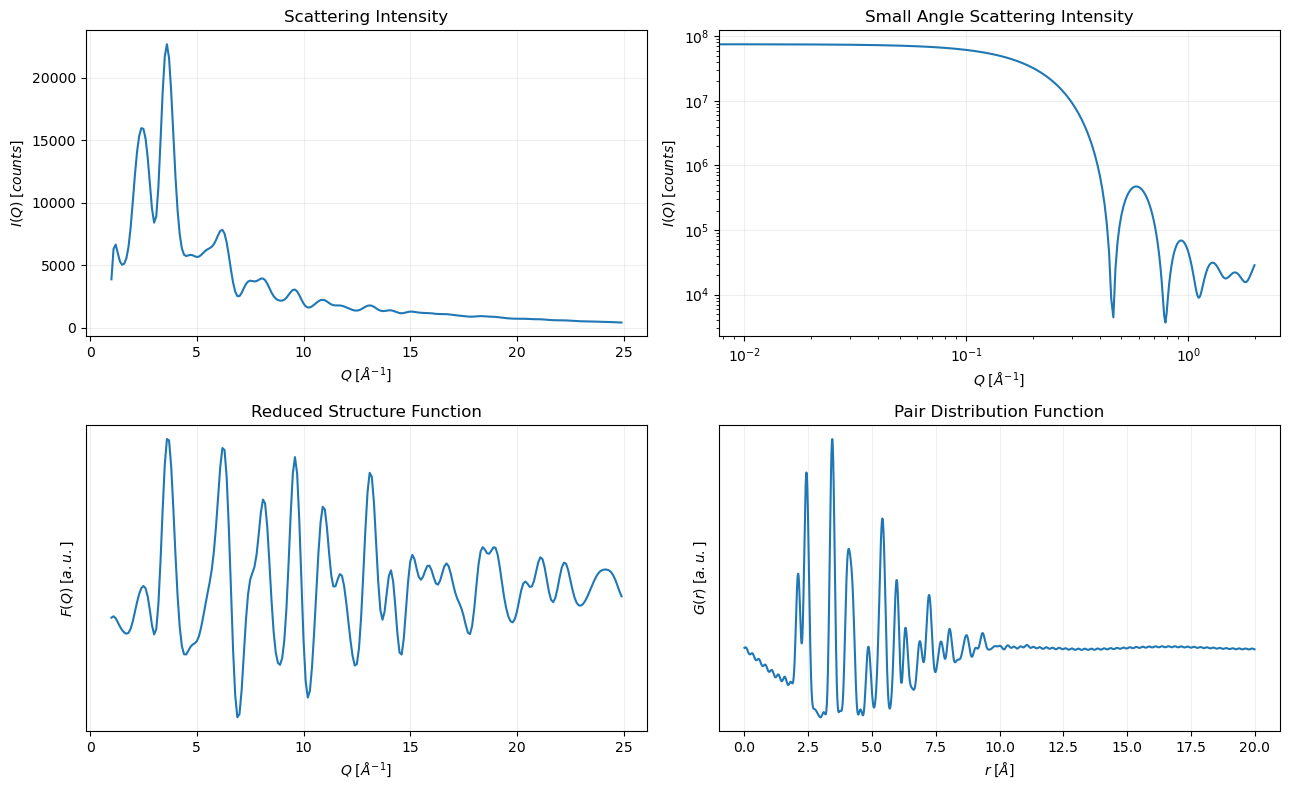

-------------------------
Nanoparticle 2: Size: 22.163 Å


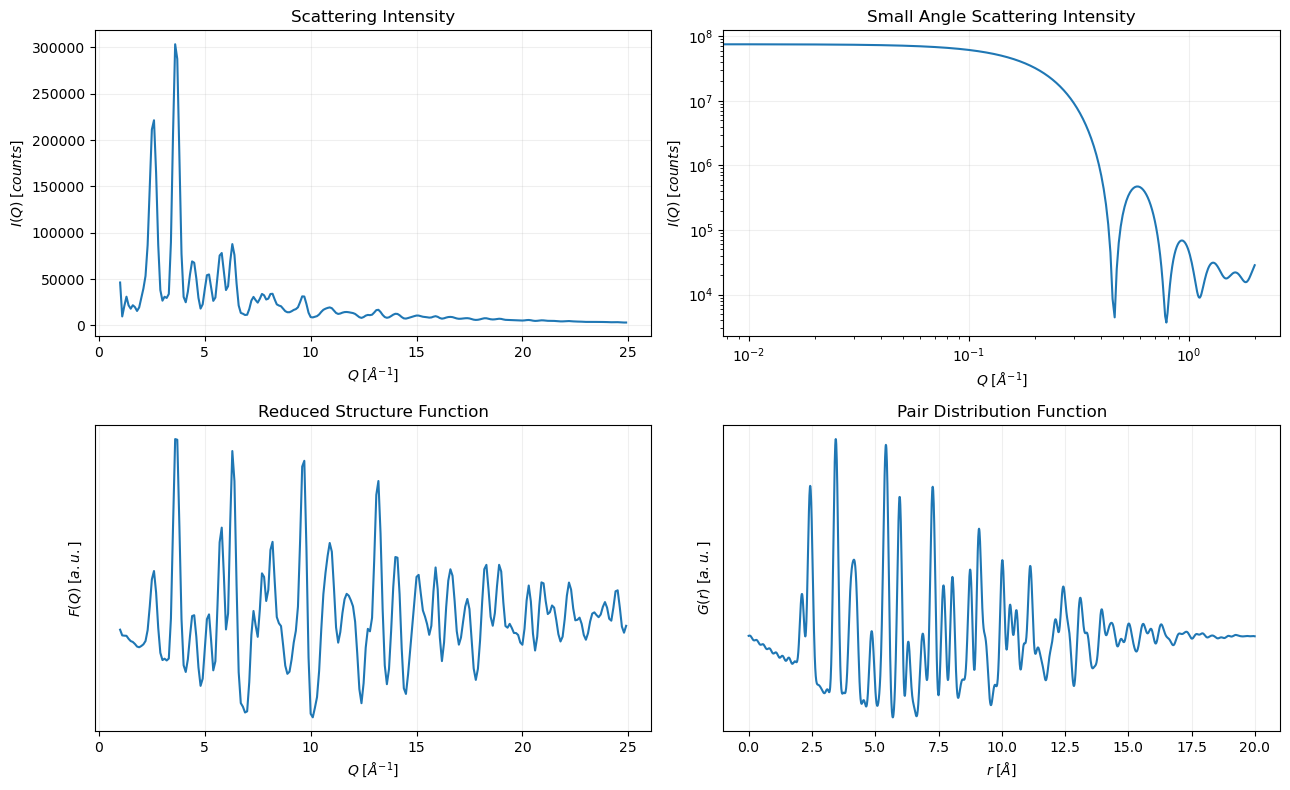

-------------------------


In [6]:
# Print nanoparticle sizes and plot their corresponding I(Q), F(Q) and G(r)
for i, (size, iq, sas, fq, gr) in enumerate(zip(nano_sizes, results_iq, results_sas, results_fq, results_gr)):
    print(f"Nanoparticle {i+1}: Size: {size:.3f} Å")
    fig, ((ax_iq, ax_sas), (ax_fq, ax_gr)) = plt.subplots(2,2, figsize=(13,8))

    ax_iq.plot(q,iq)
    ax_iq.set(xlabel='$Q \; [\AA^{-1}]$', ylabel='$I(Q) \; [counts]$')
    ax_iq.grid(alpha=0.2)
    ax_iq.set_title('Scattering Intensity')
    
    ax_sas.plot(q_sas, sas_dc)
    ax_sas.set(xlabel='$Q \; [\AA^{-1}]$', ylabel='$I(Q) \; [counts]$')
    ax_sas.grid(alpha=0.2)
    ax_sas.set_yscale('log')
    ax_sas.set_xscale('log')
    ax_sas.set_title('Small Angle Scattering Intensity')
    
    ax_fq.plot(q,fq/max(fq))
    ax_fq.set(xlabel='$Q \; [\AA^{-1}]$', ylabel='$F(Q)\; [a.u.]$', yticks=[])
    ax_fq.grid(alpha=0.2)
    ax_fq.set_title('Reduced Structure Function')
    
    ax_gr.plot(r,gr/max(gr))
    ax_gr.set(xlabel='$r \; [\AA]$', ylabel='$G(r) \; [a.u.]$', yticks=[])
    ax_gr.grid(alpha=0.2)
    ax_gr.set_title('Pair Distribution Function')
    
    fig.tight_layout()
    plt.show()

    print("-------------------------")

## Generation Comparison: DebyeCalculator vs. Diffpy CMI
The figures compares the generated data to that generated using the Diffpy-CMI package.

In [7]:
from SASCalculator import SASCalculator
import tempfile
import os
from ase.io import write
from tqdm.auto import tqdm

In [28]:
# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(device='cuda', qmin=1, qmax=40, qstep=0.01, biso=0.1, rmax=20, batch_size=4000)
dbc = DebyePDFCalculator(rmin=debye_calc.rmin, rmax=debye_calc.rmax, rstep=debye_calc.rstep,
                         qmin=debye_calc.qmin, qmax=debye_calc.qmax, qdamp=debye_calc.qdamp,
                         qstep=debye_calc.qstep)
# Choose particle
nano_particles, nano_sizes = generate_nanoparticles(structure_path, [10])
particle = nano_particles[0]

# Calculate I(Q), F(Q) and G(r) for the nanoparticles
q, iq_dc = debye_calc.iq(particle)
_, fq_dc = debye_calc.fq(particle)
r, gr_dc = debye_calc.gr(particle)

debye_calc.update_parameters(qmin=0, qmax=2)
q_sas, sas_dc = debye_calc.iq(particle)
debye_calc.update_parameters(qmin=1, qmax=40)

with tempfile.TemporaryDirectory() as tmpdirname:
    tmp_structure_path = os.path.join(tmpdirname,'tmp_struc.xyz')
    write(tmp_structure_path, particle, 'xyz')
    diffpy_structure = loadStructure(tmp_structure_path)
    diffpy_structure.B11 = debye_calc.biso
    diffpy_structure.B22 = debye_calc.biso
    diffpy_structure.B33 = debye_calc.biso
    diffpy_structure.B12 = 0
    diffpy_structure.B13 = 0
    diffpy_structure.B23 = 0

_, gr_dp = dbc(diffpy_structure)
fq_dp = dbc.fq[int(debye_calc.qmin/debye_calc.qstep):]

sc = SASCalculator(rmin=debye_calc.rmin, rmax=debye_calc.rmax, rstep=debye_calc.rstep,
                   qmin=debye_calc.qmin, qmax=debye_calc.qmax, qdamp=debye_calc.qdamp)

sc.qstep = debye_calc.qstep
_, iq_dp_full = sc(diffpy_structure)
iq_dp = iq_dp_full[int(debye_calc.qmin/debye_calc.qstep):]

Generating nanoparticles:   0%|          | 0/1 [00:00<?, ?it/s]

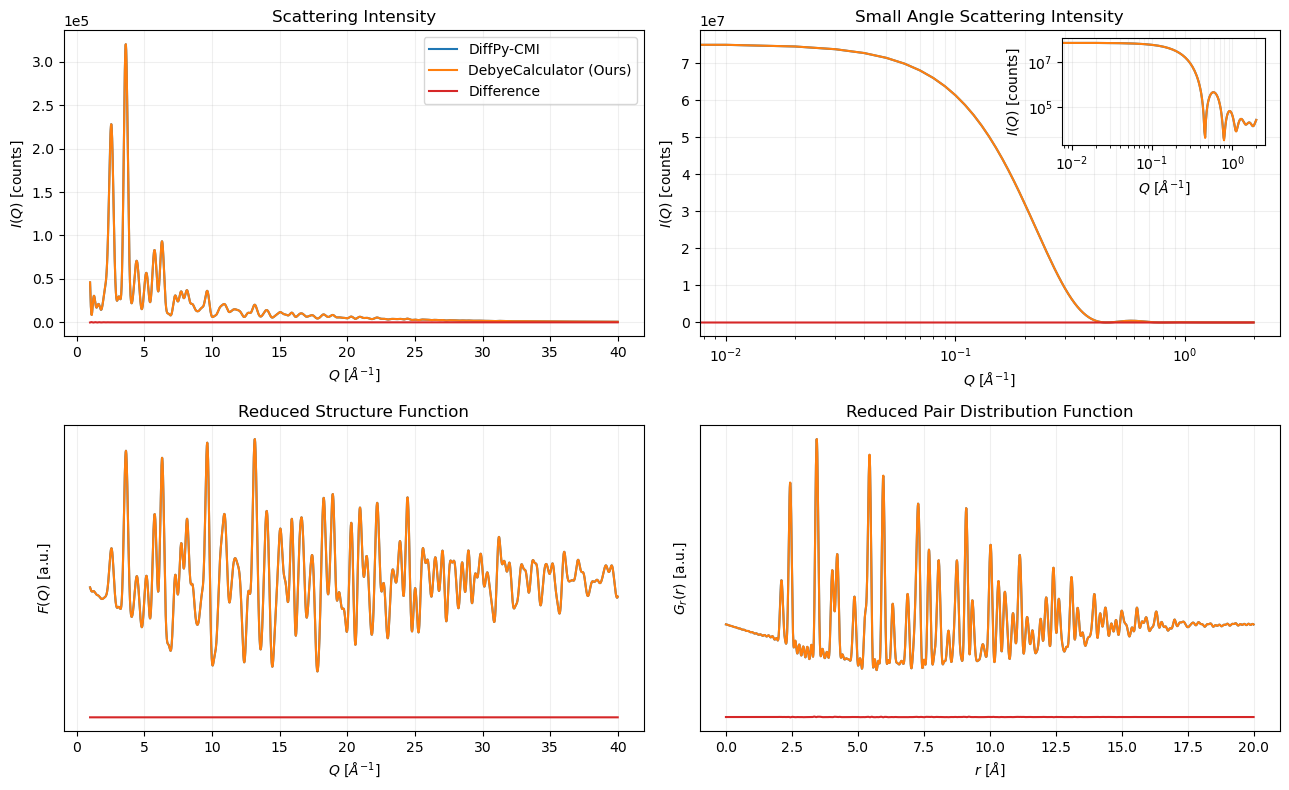

In [29]:
fig, ((ax_iq, ax_sas), (ax_fq, ax_gr)) = plt.subplots(2,2, figsize=(13,8))
    
ax_iq.plot(q,iq_dp, label='DiffPy-CMI')
ax_iq.plot(q,iq_dc, label='DebyeCalculator (Ours)')
ax_iq.plot(q,iq_dp-iq_dc, c='#d62728', label='Difference')
ax_iq.set(xlabel='$Q$ [$\AA^{-1}$]', ylabel='$I(Q)$ [counts]')
ax_iq.grid(alpha=0.2)
ax_iq.legend()
ax_iq.set_title('Scattering Intensity')
ax_iq.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax_sas.plot(q_sas, iq_dp_full[:len(q_sas)], label='DiffPy-CMI')
ax_sas.plot(q_sas, sas_dc, label='DebyeCalculator (Ours)')
ax_sas.plot(q_sas, iq_dp_full[:len(q_sas)]-sas_dc, c='#d62728', label='Difference')
ax_sas.set(xlabel='$Q$ [$\AA^{-1}$]', ylabel='$I(Q)$ [counts]')
ax_sas.grid(alpha=0.2, which='both')
ax_sas.set_xscale('log')
ax_sas.set_title('Small Angle Scattering Intensity')
ax_sas.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax_sas_inset = ax_sas.inset_axes([0.625, 0.625, 0.35, 0.35])
ax_sas_inset.plot(q_sas, iq_dp_full[:len(q_sas)], label='DiffPy-CMI')
ax_sas_inset.plot(q_sas, sas_dc, label='DebyeCalculator (Ours)')
ax_sas_inset.set_yscale('log')
ax_sas_inset.set_xscale('log')
ax_sas_inset.set(xlabel='$Q$ [$\AA^{-1}$]', ylabel='$I(Q)$ [counts]')
ax_sas_inset.grid(alpha=0.2, which='both')

ax_fq.plot(q,fq_dp/max(fq_dp), label='DiffPy-CMI')
ax_fq.plot(q,fq_dc/max(fq_dc), label='DebyeCalculator (Ours)')
ax_fq.plot(q, fq_dp/max(fq_dp) - fq_dc/max(fq_dc) - 1, c='#d62728', label='Difference')
ax_fq.set(xlabel='$Q$ [$\AA^{-1}$]', ylabel='$F(Q)$ [a.u.]', yticks=[])
ax_fq.grid(alpha=0.2)
ax_fq.set_title('Reduced Structure Function')

ax_gr.plot(r,gr_dp/max(gr_dp), label='DiffPy-CMI')
ax_gr.plot(r,gr_dc/max(gr_dc), label='DebyeCalculator (Ours)')
ax_gr.plot(r, gr_dp/max(gr_dp) - gr_dc/max(gr_dc) - 0.5, c='#d62728', label='Difference')
ax_gr.set(xlabel='$r$ [$\AA$]', ylabel='$G_r(r)$ [a.u.]', yticks=[])
ax_gr.grid(alpha=0.2)
ax_gr.set_title('Reduced Pair Distribution Function')

fig.tight_layout()

---
## Useful For Developers

### Profiling Performance with DebyeCalculator

The `DebyeCalculator` class comes with a built-in profiler that allows you to measure the time taken to execute specific parts of the code. This can be helpful in identifying performance bottlenecks and optimizing your calculations.

The profiler in `DebyeCalculator` is an instance of the `Profiling` class, which tracks the time taken by various methods in the class and provides summary statistics.

#### Profiler Demonstration

The next cell demonstrates the use of the profiler by generating nanoparticles of increasing sizes using the `generate_nanoparticle` function. We will measure the time taken to generate nanoparticles of different sizes and analyze the results using the profiler.

Let's get started!

In [30]:
from tqdm.auto import trange

In [31]:
# Load the structure file
structure_path = '../example_data/AntiFlourite_Co2O.cif'

# Generate nanoparticle
nano_particles, nano_sizes = generate_nanoparticles(structure_path, [10])

# Profiling for single particle:
debye_calc = DebyeCalculator(device='cuda', verbose=1, qmin=1, qmax=25, qstep=0.1, biso=0.3, batch_size=5000)
for _ in trange(10):
    r, gr = debye_calc.gr(nano_particles[0])

print(f"Nanoparticle Diameter: {nano_sizes[0]:.3f} Å\n")
print(debye_calc.profiler.summary(prefix='Times per data generation:'))

Generating nanoparticles:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Nanoparticle Diameter: 22.163 Å

Times per data generation:
   -> I(Q): 42.903ms +- 71.132ms (96.06%) 
   -> Setup structure and form factors: 1.561ms +- 0.854ms (3.50%) 
   -> Batching and Distances: 0.086ms +- 0.053ms (0.19%) 
   -> G(r): 0.054ms +- 0.007ms (0.12%) 
   -> S(Q): 0.034ms +- 0.010ms (0.08%) 
   -> Modifications, Qdamp/Lorch: 0.017ms +- 0.002ms (0.04%) 
   -> F(Q): 0.008ms +- 0.002ms (0.02%) 
Total: 44.663ms


---
## Speed Comparison: DebyeCalculator vs. Diffpy CMI

In this section, we will compare the speed of calculations between two different methods for calculating the Debye scattering, namely:
1. The `DebyeCalculator` class implemented in this notebook
2. The `DebyePDFCalculator` from the Diffpy CMI library

We will perform the following steps:
1. Use the `generate_nanoparticle` function to create nanoparticles of different sizes.
2. Calculate I(Q) and G(r) using the `DebyeCalculator` class for each nanoparticle.
3. Calculate I(Q) and G(r) using the `DebyePDFCalculator` from Diffpy CMI for each nanoparticle.
4. Compare the time taken by both methods using the built-in profiler.

Note that to use the `DebyePDFCalculator` from Diffpy CMI, you need to have Diffpy CMI installed in your Python environment. If you don't have it installed, you can install it using the following command:

```python
!pip install diffpy-cmi
```
**Note**: Installing the Diffpy CMI library might require a python version of 3.7 or later or 2.7. For more information visit [Diffpy-CMI](https://www.diffpy.org/products/diffpycmi/index.html).

In [34]:
# Import the script that compares the methods
from produce_figure_data import *

In [87]:
# Check if you alread have the datafiles before running this cell, so you don't have to wait
args = dict(
    cif = '../example_data/AntiFlourite_Co2O.cif',
    output_folder = '../quickstart/tutorial_output',
    min_radius = 2,
    max_radius = 20,
    step_radius = 1,
    batch_size_cpu = 4000,
    batch_size_cuda = 4000,
    figure3 = True,
    figure2 = False,
    reps = 10,
)

produce_figures(args)

Generating data for Figure 3


Generating nanoparticles:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Finished generating data for Figure 3


**Be sure to change the paths below to wherever your generated data is stored**

In [88]:
cpu_data = np.genfromtxt('../quickstart/tutorial_output/timings_cpu.csv', delimiter=',')
cuda_data = np.genfromtxt('../quickstart/tutorial_output/timings_cuda_NVIDIA RTX A3000 Laptop GPU.csv', delimiter=',') 
diffpy_data = np.genfromtxt('../quickstart/tutorial_output/timings_diffpy.csv', delimiter=',')

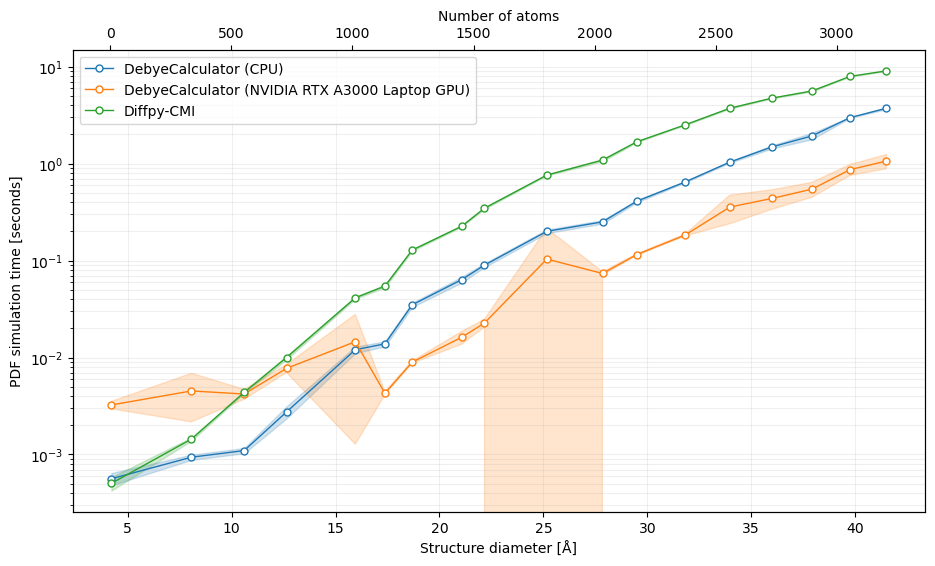

In [92]:
fig, ax = plt.subplots(figsize=(11,6))

_markersize = 5

# Ours CPU
ax.plot(cpu_data[:,0], cpu_data[:,2], c='#1f77b4',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'DebyeCalculator (CPU)')
ax.fill_between(cpu_data[:,0], cpu_data[:,2]-cpu_data[:,3], cpu_data[:,2]+cpu_data[:,3], alpha=0.2, color='#1f77b4')

# Ours GPU
ax.plot(cuda_data[:,0], cuda_data[:,2], c='#ff7f0e',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'DebyeCalculator (NVIDIA RTX A3000 Laptop GPU)')
ax.fill_between(cuda_data[:,0], cuda_data[:,2]-cuda_data[:,3], cuda_data[:,2]+cuda_data[:,3], alpha=0.2, color='#ff7f0e')

# Diffpy
ax.plot(diffpy_data[:,0], diffpy_data[:,2], c='#2ca02c',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Diffpy-CMI')
ax.fill_between(diffpy_data[:,0],diffpy_data[:,2]-diffpy_data[:,3], diffpy_data[:,2]+diffpy_data[:,3], alpha=0.2, color='#2ca02c')

ax.set_ylabel('PDF simulation time [seconds]')
ax.set_xlabel('Structure diameter [Å]')  
ax.grid(alpha=0.2, which="both")
ax.legend()
ax.set_yscale('log')

ax_atoms = ax.twiny()
ax_atoms.plot(cpu_data[:,1], np.zeros_like(cpu_data[:,1]), alpha=0.0)
ax_atoms.set(xlabel='Number of atoms')
plt.show()

# # Save figure to paper
# fig.savefig('../figures/figure3.png', dpi=300)

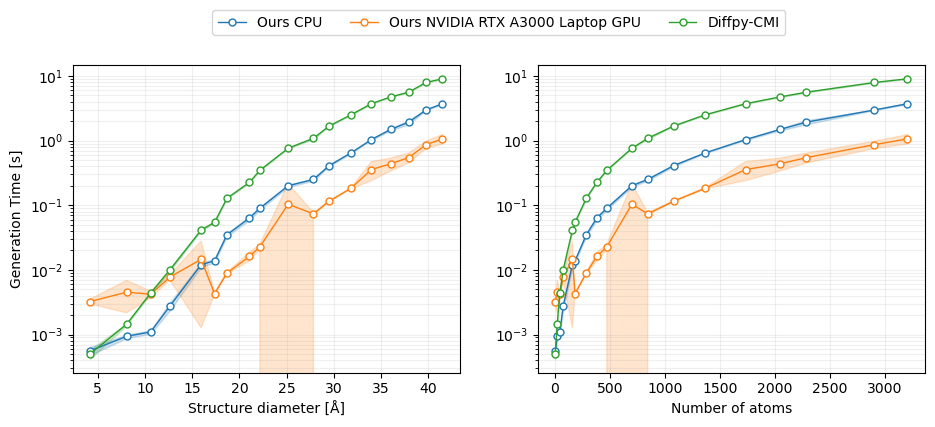

In [90]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,4))

_markersize = 5

# Ours CPU
ax1.plot(cpu_data[:,0], cpu_data[:,2], c='#1f77b4',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours CPU')
ax1.fill_between(cpu_data[:,0], cpu_data[:,2]-cpu_data[:,3], cpu_data[:,2]+cpu_data[:,3], alpha=0.2, color='#1f77b4')

# Ours GPU
ax1.plot(cuda_data[:,0], cuda_data[:,2], c='#ff7f0e',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours NVIDIA RTX A3000 Laptop GPU')
ax1.fill_between(cuda_data[:,0], cuda_data[:,2]-cuda_data[:,3], cuda_data[:,2]+cuda_data[:,3], alpha=0.2, color='#ff7f0e')

# Diffpy
ax1.plot(diffpy_data[:,0], diffpy_data[:,2], c='#2ca02c',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Diffpy-CMI')
ax1.fill_between(diffpy_data[:,0], diffpy_data[:,2]-diffpy_data[:,3], diffpy_data[:,2]+diffpy_data[:,3], alpha=0.2, color='#2ca02c')

ax1.set_ylabel('Generation Time [s]')
ax1.set_xlabel('Structure diameter [Å]')  
ax1.grid(alpha=0.2, which="both")
ax1.legend()
ax1.set_yscale('log')

# Ours CPU
ax2.plot(cpu_data[:,1], cpu_data[:,2], c='#1f77b4',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours CPU')
ax2.fill_between(cpu_data[:,1], cpu_data[:,2]-cpu_data[:,3], cpu_data[:,2]+cpu_data[:,3], alpha=0.2, color='#1f77b4')

# Ours GPU
ax2.plot(cuda_data[:,1], cuda_data[:,2], c='#ff7f0e',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours NVIDIA RTX A3000 Laptop GPU')
ax2.fill_between(cuda_data[:,1], cuda_data[:,2]-cuda_data[:,3], cuda_data[:,2]+cuda_data[:,3], alpha=0.2, color='#ff7f0e')

# Diffpy
ax2.plot(diffpy_data[:,1], diffpy_data[:,2], c='#2ca02c',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Diffpy-CMI')
ax2.fill_between(diffpy_data[:,1], diffpy_data[:,2]-diffpy_data[:,3], diffpy_data[:,2]+diffpy_data[:,3], alpha=0.2, color='#2ca02c')

ax2.set_xlabel('Number of atoms')  
ax2.grid(alpha=0.2, which="both")
# Put a legend below current axis
ax1.legend(loc='upper center', bbox_to_anchor=(1.1, 1.2),
          fancybox=True, shadow=False, ncol=3)
ax2.set_yscale('log')
# ax2.set_xscale('log')

# fig.tight_layout()

plt.show()